# Development of filter to estimate real gas consumption on pulsed meters

Sub-metering is used in building to identify what energy end uses are responsible for energy use and thus to identify wasteful energy consumption. Frequently, information logged on sub-meters is recorded to the Building Management System (BMS) via pulsed output. When the meter has logged a discrete energy consumpiton, say 1kWh, it send as signal to the BMS that 1kWh has been consumed. The BMS then frequently records this information on a fixed interval, say every 30 minutes the number of pulses counted in that period will be logged.

This setup can be problematic when the amount of energy consumed at a meter is low with respect to the amount required to trigger a pulse. In the example below, a gas meter pulses only when 110kWh of gas has been consumed. Frequently gas use in the building is too low trigger a pulse during a 30 minute interval, leading to a jagged/sawtooth pattern in gas consumption that does not give a true reflection of gas use.

This notebook attempts to investigate the effectivess of a filtering/smoothing algorithm in providing a closer representation of actual gas use.

## Imports and Definitions

In [1]:
import pandas as pd
import seaborn as sns # for nice looking plots

%matplotlib inline

In [2]:
def pulse_filter(series, increment, remainder=0):
    """Filters raw input data to mimic the output that might be produced by
    a pulsed meter.
    
    The series is the raw data and the increment is the minimum value that 
    triggers a pulse"""
    
    pulses = []
    
    for n, i in enumerate(series):
        i = i + remainder
                
        remainder = i % increment
        pulse = i - remainder
                
        pulses.append(pulse)
    
    return pulses

## Load the raw data file

In this example simulated gas used as the raw data. It is then passed through a filter to approximate the output which would be achieved through a pulsed meter.

In [7]:
df = pd.read_csv('Gas.csv', index_col=0, parse_dates=True, dayfirst=True)
df.columns = ['Real'] #rename column headers

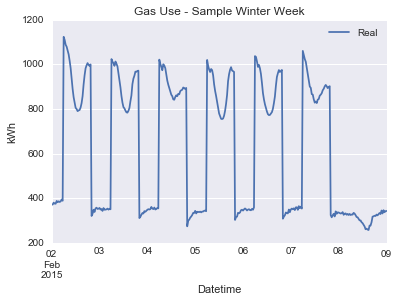

In [13]:
ax = df.truncate(before='2015-02-02', after='2015-02-09').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Winter Week')

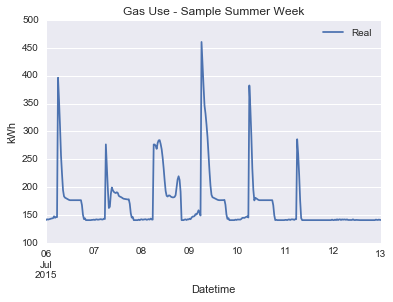

In [16]:
ax = df.truncate(before='2015-07-06', after='2015-07-13').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Summer Week')

## Generate Pulsed Meter Output

In [30]:
df['Meter'] = pulse_filter(df.Real, 110)
df['Meter'].to_csv('metered_gas.csv')

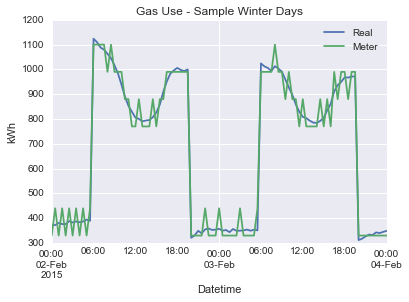

In [28]:
ax = df.truncate(before='2015-02-02', after='2015-02-04').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Winter Days')

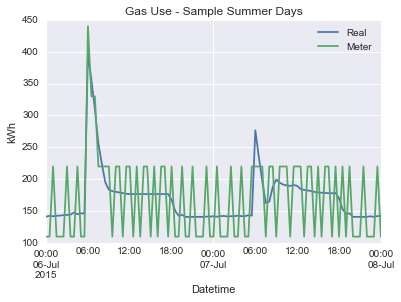

In [27]:
ax = df.truncate(before='2015-07-06', after='2015-07-08').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Summer Days')